###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from micrograd.engine import Value
#from micrograd.nn import Neuron, Layer, MLP
from littlegrad2.engine import Tensor

In [3]:
np.random.seed(1337)
random.seed(1337)

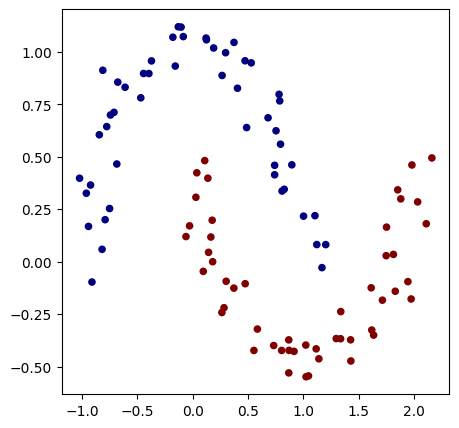

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

#y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
class LinearNet:
    def __init__(self):
        self.params = {
            'w1' : Tensor(2 * np.random.random_sample((2, 25)) - 1),
            'b1' : Tensor(np.zeros((1, 25))),
            'w2' : Tensor(2 * np.random.random_sample((25, 15)) - 1),
            'b2' : Tensor(np.zeros((1, 15))),
            'w3' : Tensor(2 * np.random.random_sample((15, 2)) - 1),
            'b3' : Tensor(np.zeros((1, 2)))
        }

    def parameters(self):
        return self.params.values()
    
    def zero_grad(self):
        for param in self.params.values():
            param.grad.fill(0)

    def param_num(self):
        return np.sum([t.data.size for t in self.params.values()])
            
    def __call__(self, x:Tensor) -> Tensor:
        return ((x@self.params['w1']+self.params['b1']).relu()@self.params['w2']+self.params['b2']).relu()@self.params['w3']+self.params['b3']

model = LinearNet()
print(model.param_num())

497


In [6]:
def softmax(logits):
  counts = logits.exp()
  denominator = counts @ np.ones(shape = (counts.data.shape[-1], counts.data.shape[-1])) #2D ones matrix avoids denom broadcasting which fucks up gradient shape
  return counts / denominator, logits - denominator.log() #probs, log_softmax

#X = (X-np.average(X)) / np.std(X)  #data normalization
def loss(X, y, model, batch_size=None):

    if batch_size is None:  #dataloader
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] #shuffles the X indexes and returns the first 10
        Xb, yb = X[ri], y[ri]

    probs, log_softmax = softmax(model(Tensor(Xb))) # x --(model)--> logits --(softmax)--> probs --(-log)--> nll loss
    losses = Tensor(np.zeros_like(probs.data))
    losses.data[np.arange(probs.data.shape[0]), yb] = -1
    losses = (losses * log_softmax).flatten() @ Tensor(np.ones((probs.data.size, 1))) / probs.data.shape[0]
    #losses = losses @ Tensor(np.ones((probs.data.shape[0], 1)) / probs.data.shape[0]) # averaging nll losses to calculate cost
    accuracy = np.average(np.argmax(probs.data, axis = -1) == yb)

    # L2 regularization
    alpha = 0
    reg_loss = alpha * sum([p.flatten()@p.flatten().transpose() for p in model.parameters()])
    return losses + reg_loss, accuracy # (total_loss = data_loss + reg_loss)


In [7]:
learning_rate, beta1, beta2, epsilon, weight_decay = 0.09, 0.9, 0.999, 1e-10, 0.01
# optimization
for k in range(75):
    
    # forward
    total_loss, acc = loss(X, y, model)

    # backward
    model.zero_grad()
    total_loss.backprop()
    
    #update parameters w/ AdamW Algorithm
    for p in model.parameters(): 
        p.data -= p.data * learning_rate * weight_decay
        p.v = (beta1 * p.v) + ((1-beta1) * p.grad)
        p.s = (beta2 * p.s) + ((1-beta2) * p.grad * p.grad)
        v_dp_corrected = p.v / (1 - (beta1**(k+1)))
        s_dp_corrected = p.s / (1 - (beta2**(k+1)))
        p.data -= learning_rate * v_dp_corrected / (np.sqrt(s_dp_corrected) + epsilon)

    print(f"step {k} loss {total_loss.data.real[0, 0]}, accuracy {acc*100}%")


step 0 loss 0.5507917671563728, accuracy 52.0%
step 1 loss 0.8441618060064521, accuracy 73.0%
step 2 loss 0.4873551414717266, accuracy 82.0%
step 3 loss 0.40021282286483184, accuracy 87.0%
step 4 loss 0.4446306127048424, accuracy 83.0%
step 5 loss 0.49477205316156475, accuracy 83.0%
step 6 loss 0.3999086130412672, accuracy 83.0%
step 7 loss 0.33926759670267315, accuracy 86.0%
step 8 loss 0.31979154162769846, accuracy 87.0%
step 9 loss 0.29326378580978346, accuracy 85.0%
step 10 loss 0.27172821561209637, accuracy 85.0%
step 11 loss 0.27041704959749235, accuracy 87.0%
step 12 loss 0.27360664185298184, accuracy 87.0%
step 13 loss 0.26561058761132533, accuracy 86.0%
step 14 loss 0.25650825662543986, accuracy 86.0%
step 15 loss 0.25271181560532097, accuracy 86.0%
step 16 loss 0.2500559433675488, accuracy 85.0%
step 17 loss 0.24403251414187802, accuracy 86.0%
step 18 loss 0.23950750634853873, accuracy 84.0%
step 19 loss 0.24046187393672178, accuracy 86.0%
step 20 loss 0.24171419384120682, ac

(-1.548639298268643, 1.951360701731357)

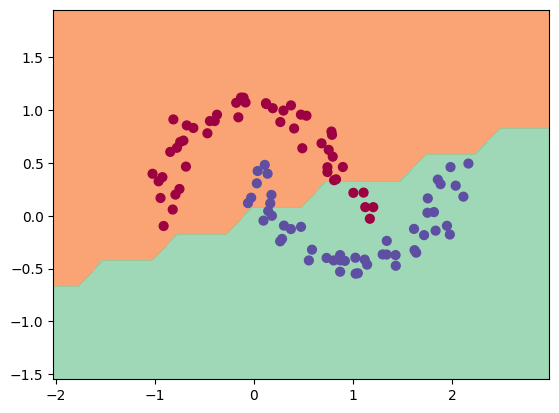

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
probs, log_softmax = softmax(model(Tensor(Xmesh)))
scores = np.argmax(probs.data, axis = -1)

Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


In [9]:
test = np.arange(12).reshape(3, 4)
print(test)
poop = slice(1, -1), slice(1, 3)
print(poop)
print(test[poop])
grad = np.array([10, 10])
cringe = test[poop]
cringe *= grad
print(test)

# poop = np.array([[0, 1, 0, 0, 0]]).T
# print(test.shape)
# print(poop.shape)
#print(test)
#test = test.reshape(2, 3, 4, 5)
# out = (test@poop).reshape(2, 3, 4, 1)
#print(test)
# print(out)
# print(out.shape)

# test = np.arange(24).reshape(2, 12)
# print(test)
# test = test.reshape(2, 3, 4)
# print(test)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
(slice(1, -1, None), slice(1, 3, None))
[[5 6]]
[[ 0  1  2  3]
 [ 4 50 60  7]
 [ 8  9 10 11]]


In [10]:
test = np.arange(12).reshape(3, 4)
print(test)

f = 2
#poop = np.ndarray(shape = (test.shape[0]-f, test.shape[1]-f))
poop = []
for x in range(test.shape[0]-f+1):
    for y in range(test.shape[1]-f+1):
        #poop[x, y] = test[slice(x, x+f), slice(y, y+f)]
        poop.append(test[slice(x, x+f), slice(y, y+f)])

poop = np.array(poop)*10
# poop = np.array([[slice(1, -1), slice(1, 3)]])
# print('poop: ', poop)
# grad = np.array([[10, 10]])
# print('test[poop[0, 0]]: ', test[poop[0, 0]])
# cringe = np.array([[test[poo] for poo in poop[0]]])
# print(cringe)
# neugh = np.ones(shape=())
# print(neugh)
# cringe *= neugh
#cringe *= grad
print(test)
for poo in poop:
    print(poo)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0 10]
 [40 50]]
[[10 20]
 [50 60]]
[[20 30]
 [60 70]]
[[40 50]
 [80 90]]
[[ 50  60]
 [ 90 100]]
[[ 60  70]
 [100 110]]


In [11]:
test = np.arange(120).reshape((1, 2, 3, 4, 5))
print(test)
print(test.reshape((5, -1)).reshape((1, 2, 3, 4, 5)))

[[[[[  0   1   2   3   4]
    [  5   6   7   8   9]
    [ 10  11  12  13  14]
    [ 15  16  17  18  19]]

   [[ 20  21  22  23  24]
    [ 25  26  27  28  29]
    [ 30  31  32  33  34]
    [ 35  36  37  38  39]]

   [[ 40  41  42  43  44]
    [ 45  46  47  48  49]
    [ 50  51  52  53  54]
    [ 55  56  57  58  59]]]


  [[[ 60  61  62  63  64]
    [ 65  66  67  68  69]
    [ 70  71  72  73  74]
    [ 75  76  77  78  79]]

   [[ 80  81  82  83  84]
    [ 85  86  87  88  89]
    [ 90  91  92  93  94]
    [ 95  96  97  98  99]]

   [[100 101 102 103 104]
    [105 106 107 108 109]
    [110 111 112 113 114]
    [115 116 117 118 119]]]]]
[[[[[  0   1   2   3   4]
    [  5   6   7   8   9]
    [ 10  11  12  13  14]
    [ 15  16  17  18  19]]

   [[ 20  21  22  23  24]
    [ 25  26  27  28  29]
    [ 30  31  32  33  34]
    [ 35  36  37  38  39]]

   [[ 40  41  42  43  44]
    [ 45  46  47  48  49]
    [ 50  51  52  53  54]
    [ 55  56  57  58  59]]]


  [[[ 60  61  62  63  64]
    [ 65  66  

In [22]:
#a = Tensor(np.array([[1, 2, 3, 0, 0, 0]]))
#b = Tensor(np.array([[0, 1, 0.5, 0, 0, 0, 0]]))
#b = Tensor(np.array([[0.5, 1, 0, 0, 0, 0]]))
# a = Tensor(np.array([[10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0]]))

# b = Tensor(np.array([[1, 0, -1],
#                      [1, 0, -1],
#                      [1, 0, -1]]))

#a = Tensor(np.array([[1., 2., 3., 0, 0]]))
#b = Tensor(np.array([[0, 1, 0.5]]))

#a = Tensor(np.array([[1, 2-1j, -1j, -1+2j]])) #from wikipedia's dft article
#b = a.transpose()

# a = Tensor(np.array([[1, 0, 2, 0, 1, 0],
#                      [0, 1, 0, 1, 0, 4],
#                      [5, 0, 1, 0, 1, 0],
#                      [0, 1, 0, 3, 0, 9],
#                      [1, 0, 7, 0, 1, 0],
#                      [0, 6, 0, 1, 0, 8]]))

# b = Tensor(np.array([[1, 1, -1],
#                      [1, 0, -1],
#                      [1, 0, -1]]))

a = Tensor(np.array([[[10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0]]]))

b = Tensor(np.array([[[[1, 0, -1],
                     [1, 0, -1],
                     [1, 0, -1]]],
                     [[[-1, 0, 1],
                     [-1, 0, 1],
                     [-1, 0, 1]]]]))

#a = Tensor(np.ones(shape = (1, 28, 28)))
#b = Tensor(np.ones(shape = (6, 1, 5, 5)))

def dftNd(self):
    out = Tensor(data = self.data)
    dims = np.arange(len(self.data.shape))
    for dim in dims:
        shape = out.data.shape
        dftMatrix = np.arange(shape[0]).reshape((-1, 1)) @ np.arange(shape[0]).reshape((1, -1))
        out = (out.reshape((-1, shape[0])) @ np.exp(-2j * np.pi * dftMatrix / shape[0])).reshape(shape).transpose()
    return out

def idftNd(self):
    out = Tensor(data = self.data)
    dims = np.arange(len(self.data.shape))
    for dim in dims:
        shape = out.data.shape
        dftMatrix = np.arange(shape[0]).reshape((-1, 1)) @ np.arange(shape[0]).reshape((1, -1))
        out = ((out.reshape((-1, shape[0])) @ np.exp(2j * np.pi * dftMatrix / shape[0])) / shape[0]).reshape(shape).transpose()
    return out

# NOTE: BACKWARD PASS NO WORK
def conv(self, other, stride = 1): # TODO: enforce correct matrix dims?
    other = other if type(other) == Tensor else Tensor(other)
    (nc, nx, ny) = self.data.shape # NOTE: CHANNELS FIRST
    (fn, fc, fx, fy) = other.data.shape # NOTE: FILTERS & CHANNELS FIRST
    out = Tensor(data = np.zeros(shape = (fn, ((nx-fx)//stride)+1, ((ny-fy)//stride)+1)))
    for f in range(fn):
        otherPadded = Tensor(data = np.zeros_like(self.data)).sliceAdd(other.slice((f)).flip(), (slice(fc), slice(fx), slice(fy)))
        out = out.sliceAdd((self.dftNd() * otherPadded.dftNd()).idftNd().slice((slice(0, 1, stride), slice(fx-1, nx, stride), slice(fy-1, ny, stride))), (slice(f, f+1), slice(out.data.shape[-2]), slice(out.data.shape[-1])))
    return out

def avgPool(self, filter_size = 2, stride = 2):
    (nc, nx, ny) = self.data.shape
    out = Tensor(data = np.zeros(shape = (nc, nx//stride, ny//stride)))
    filter = np.ones(shape = (1, 1, filter_size, filter_size))/(filter_size**2)
    for c in range(nc):
        out = out.sliceAdd(self.slice((slice(c, c+1))).conv(filter, stride = stride), (slice(c, c+1)))
    return out

def maxPool2d(self, filter_size = 2, stride = 2): # NOTE: FORWARD PASS NO WORK
    (nc, nx, ny) = self.data.shape
    out = Tensor(data = np.ndarray(shape = (nc, nx//stride, ny//stride)), children = (self,), op = 'pool')
    for c in range(out.data.shape[0]):
        for x in range(out.data.shape[1]):
            for y in range(out.data.shape[2]):
                out.sliceAdd(self.slice((slice(c, c+1), slice(x*stride, x*stride+filter_size), slice(y*stride, y*stride+filter_size))).max(), (slice(c, c+1), slice(x, x+1), slice(y, y+1)))
    return out

print('a: ', a.data.shape, '\n', a.data.real)
print('b: ', b.data.shape, '\n', b.data.real)

c = maxPool2d(conv(a, b))
print('a.conv(b): ', c.data.shape, '\n', np.round(c.data.real))

a:  (1, 6, 6) 
 [[[10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]]]
b:  (2, 1, 3, 3) 
 [[[[ 1.  0. -1.]
   [ 1.  0. -1.]
   [ 1.  0. -1.]]]


 [[[-1.  0.  1.]
   [-1.  0.  1.]
   [-1.  0.  1.]]]]
a.conv(b):  (2, 2, 2) 
 [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]


In [13]:
test = np.arange(5)
for n in test:
    print(np.roll(test, n))

test = np.arange(20).reshape((1, 4, 5))
print(test)
print(test[(0, slice(3), slice(2))])

[0 1 2 3 4]
[4 0 1 2 3]
[3 4 0 1 2]
[2 3 4 0 1]
[1 2 3 4 0]
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]]]
[[ 0  1]
 [ 5  6]
 [10 11]]


In [14]:
a = Tensor(np.ones(shape = (1, 28, 28)))
b = Tensor(np.ones(shape = (6, 1, 5, 5))/25)
filter_size, stride = 2, 2
(nc, nx, ny) = a.data.shape
(fn, fc, fx, fy) = b.data.shape
print('a: ', a.data.shape)
print('b: ', b.data.shape)

c = a.conv(b)
print('c: ', c.data.shape)
test = np.ones(shape = (1, 1, filter_size, filter_size))/(filter_size**2)
d = Tensor(np.zeros(shape = (c.data.shape[0], c.data.shape[1]//stride, c.data.shape[2]//stride)))
for f in range(fn):
    d = d.sliceAdd(c.slice((slice(f, f+1))).conv(test, stride = stride), (slice(f, f+1)))
print('test: ', test)
#d = c.conv(test, stride = stride)
print('d: ', d.data.shape, '\n', np.round(d.data.real, 2))

a:  (1, 28, 28)
b:  (6, 1, 5, 5)
c:  (6, 24, 24)
test:  [[[[0.25 0.25]
   [0.25 0.25]]]]
d:  (6, 12, 12) 
 [[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1.

In [15]:
test = np.arange(20).reshape(4, 5)
print(test)

print(test[[0, 1, 2, 3], [0, 1, 2, 3]])
print(test[range(4), range(4)])
print(test[np.arange(4), np.arange(4)])

poop = [[ 0,  1,  2,  3,  4],
 [ 5,  6,  7,  8,  9],
 [10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19]]
print(poop)

#print(poop[[0, 1, 2, 3], [0, 1, 2, 3]])
#print(poop[range(4), range(4)])
#print(poop[np.arange(4), np.arange(4)])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
[ 0  6 12 18]
[ 0  6 12 18]
[ 0  6 12 18]
[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19]]


In [16]:
test = np.arange(10,  dtype=np.float64)
print(test)
testtest = (test == 0) * 1e-10
#print(~test)
print(np.log(test + ((test == 0)*1e-10)))

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[-23.02585093   0.           0.69314718   1.09861229   1.38629436
   1.60943791   1.79175947   1.94591015   2.07944154   2.19722458]


In [17]:
test = np.arange(5).reshape(-1, 1)
test2 = np.ndarray((5, 5))
print(test, test.shape)

np.copyto(test2, test)
test2[0, 0] = 69
print(test2)

[[0]
 [1]
 [2]
 [3]
 [4]] (5, 1)
[[69.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.]]


In [52]:
shape = [3]
dftMatrix = np.arange(shape[0]).reshape((-1, 1)) @ np.arange(shape[0]).reshape((1, -1))
print(dftMatrix, dftMatrix.shape, "[correct dft]")

test = np.arange(18).reshape(1, 2, 3, 3)
print(test, test.shape, "[test]")

poop = test @ np.round(np.exp(-2j * np.pi * dftMatrix / shape[0]), 2)
print(poop, poop.shape, "[test @ correct dftMatrix]")

#test = np.array([[1, 2-1j, -1j, -1+2j]]).T #from wikipedia's dft article

def dftNd(self):
    out = self
    dims = np.arange(len(self.data.shape))
    for dim in dims:
        shape = out.data.shape
        print('shape: ', shape)
        dftMatrix = np.arange(shape[-1]).reshape((-1, 1)) @ np.arange(shape[-1]).reshape((1, -1))
        #print('dftMatrix: ', dftMatrix.shape, '\n', np.round(np.exp(-2j * np.pi * dftMatrix / shape[-1]), 2))
        #print('out: ', out.shape, '\n', np.round(out, 2))
        #out = (out.reshape((-1, shape[0])) @ np.exp(-2j * np.pi * dftMatrix / shape[0])).reshape(shape).transpose()
        out = (out @ np.exp(-2j * np.pi * dftMatrix / shape[-1])).transpose()
        #out = (out @ np.exp(-2j * np.pi * dftMatrix / shape[0])).transpose()
    return out

np.round(dftNd(test), 2)

[[0 0 0]
 [0 1 2]
 [0 2 4]] (3, 3) [correct dft]
[[[[ 0  1  2]
   [ 3  4  5]
   [ 6  7  8]]

  [[ 9 10 11]
   [12 13 14]
   [15 16 17]]]] (1, 2, 3, 3) [test]
[[[[ 3. +0.j   -1.5+0.87j -1.5-0.87j]
   [12. +0.j   -1.5+0.87j -1.5-0.87j]
   [21. +0.j   -1.5+0.87j -1.5-0.87j]]

  [[30. +0.j   -1.5+0.87j -1.5-0.87j]
   [39. +0.j   -1.5+0.87j -1.5-0.87j]
   [48. +0.j   -1.5+0.87j -1.5-0.87j]]]] (1, 2, 3, 3) [test @ correct dftMatrix]
shape:  (1, 2, 3, 3)
shape:  (3, 3, 2, 1)
shape:  (1, 2, 3, 3)
shape:  (3, 3, 2, 1)


array([[[[ 0.-0.j,  6.+0.j,  3.-0.j],
         [ 9.-0.j, 15.+0.j, 12.-0.j],
         [18.-0.j, 24.+0.j, 21.+0.j]],

        [[27.-0.j, 33.+0.j, 30.+0.j],
         [36.-0.j, 42.+0.j, 39.+0.j],
         [45.-0.j, 51.+0.j, 48.+0.j]]]])

In [63]:
x = np.array([1, 2, 3])

shape = (3, 3)
test = np.ndarray(shape)
np.copyto(dst = test, src = np.broadcast_to(x, shape))

test[0, 0] = 69
print(test)

[[69.  2.  3.]
 [ 1.  2.  3.]
 [ 1.  2.  3.]]


In [68]:
test = np.ndarray((1, 2, 3, 4))
test2 = np.ndarray((8, 9))
poopDim = np.array(test.shape)
poopDim[-2:] = test2.shape[:]
poop = np.ndarray(poopDim)
print(poop.shape)

(1, 2, 8, 9)
